# Identify Fraud from Enron Email
**Machine Learning Project — Udacity Data Analyst Nanodegree**

### Dataset Background
In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives. This data comes with a hand-generated list of persons of interest in the fraud case, which means individuals who were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity. In this project, I will try my best to build a person of interest identifier based on financial and email data made public as a result of the Enron scandal.

Below cell basically consists only of the provided starter code:

## Data Exploration

In [1]:
import os
os.chdir('C:/Users/Rapha/Documents/Datascience_Nanodegree/Projekte/Project4/For_submission')

import sys
import pickle

sys.path.append(os.getcwd())
sys.path.append('C:/Users/Rapha/Documents/Datascience_Nanodegree/Projekte/Project4/tools')

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

import poi_plot, poi_explore

### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".

payment_data = ['salary',
                'bonus',
                'long_term_incentive',
                'deferred_income',
                'deferral_payments',
                'loan_advances',
                'other',
                'expenses',                
                'director_fees', 
                'total_payments',
                'exercised_stock_options',
                'restricted_stock',
                'restricted_stock_deferred',
                'total_stock_value']

email_data = ['to_messages',
              'from_messages',
              'from_poi_to_this_person',
              'from_this_person_to_poi',
              'shared_receipt_with_poi']

features_list = ['poi'] + payment_data + email_data # You will need to use more features

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

### Store to my_dataset for easy export below.
my_dataset = data_dict

C:\Users\Rapha\anaconda3\envs\python2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


The starter code will output the data in the form of a Python dictionary where each key-value pair corresponds to one person. The key is the person's name, and the value is another dictionary. 

For easier handling I will convert it to a pandas dataframe.

In [2]:
#create new dataframe from dict
df = pd.DataFrame.from_dict(data_dict, orient='index')
#parse 'NaN' values as np.nan
df = df.replace('NaN', np.nan)

To get a view on the size of our data we can either just call the general info or specifically query the number of persons and features:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 21 columns):
salary                       95 non-null float64
to_messages                  86 non-null float64
deferral_payments            39 non-null float64
total_payments               125 non-null float64
exercised_stock_options      102 non-null float64
bonus                        82 non-null float64
restricted_stock             110 non-null float64
shared_receipt_with_poi      86 non-null float64
restricted_stock_deferred    18 non-null float64
total_stock_value            126 non-null float64
expenses                     95 non-null float64
loan_advances                4 non-null float64
from_messages                86 non-null float64
other                        93 non-null float64
from_this_person_to_poi      86 non-null float64
poi                          146 non-null bool
director_fees                17 non-null float64
deferred_income              49 non-null float

From the info query I can see that all values are parsed in floating point format except from "email_address" and "POI", with the latter being a boolean.

In addition to that one can notice that the dataset contains many missing 'null'/'nan' values. In the next chapter I will elaborate on how to interpret and treat these.

In [4]:
print 'Number of people in the Enron dataset: {0}'.format(len(df))
print 'Number of features for each person in the Enron dataset: {0}'.format(len(df.iloc[0]))

Number of people in the Enron dataset: 146
Number of features for each person in the Enron dataset: 21


There are 146 rows in the dataset which correspond to 146 individuals and 21 features.

By overwriting the dataframe with only the features list I deliberately disregard the column "email_address" since this will not be of value. After that we will be left with 20 features.

In [5]:
df = df[features_list]

In [6]:
print 'Number of features for each person in the Enron dataset: {0}'.format(len(df.iloc[0]))

Number of features for each person in the Enron dataset: 20


In [7]:
pois = df['poi'].loc[df['poi'] == True]
print 'Number of POI\'s: {0}'.format(len(pois))

Number of POI's: 18


### NaN Value Treatment

Taking a look into the original Pdf-file for the financial data my interpretation is that empty fields do not stand for unknown quantities but represent "0". However for the e-mail data NaNs are unknown information. 

For that reason I will replace any financial data which is NaN with a "0" whereas for the e-mail data I will replace NaN values with the mean of the respective column grouped by POIs and Non-POIS. In other words if a NaN-value corresponds to a POI it will be filled with the mean of the POIs in that column and if a NaN value correspsonds to a Non-POI it will be filled with the mean of the Non-POIs in that column. If I chose to drop all NaNs it would reduce the size of what is already a small dataset. Since the perfomance of a machine learning algorithm is proportional to the amount of data fed into it, I am hesitant to remove any information that could possibly be of use.

In [8]:
df.isnull().sum(axis = 0)

poi                            0
salary                        51
bonus                         64
long_term_incentive           80
deferred_income               97
deferral_payments            107
loan_advances                142
other                         53
expenses                      51
director_fees                129
total_payments                21
exercised_stock_options       44
restricted_stock              36
restricted_stock_deferred    128
total_stock_value             20
to_messages                   60
from_messages                 60
from_poi_to_this_person       60
from_this_person_to_poi       60
shared_receipt_with_poi       60
dtype: int64

In [9]:
# Fill in the NaN payment and stock values with zero 
df[payment_data] = df[payment_data].fillna(0)

In [10]:
from sklearn.preprocessing import Imputer

# Fill in the NaN email data with the mean of column grouped by poi/ non_poi
imp = Imputer(missing_values='NaN', strategy = 'mean', axis=0)

df_poi = df[df['poi'] == True];
df_nonpoi = df[df['poi']==False]

df_poi.loc[:, email_data] = imp.fit_transform(df_poi.loc[:,email_data]);
df_nonpoi.loc[:, email_data] = imp.fit_transform(df_nonpoi.loc[:,email_data]);
df = df_poi.append(df_nonpoi)

C:\Users\Rapha\anaconda3\envs\python2\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [11]:
df.isnull().sum(axis = 0)

poi                          0
salary                       0
bonus                        0
long_term_incentive          0
deferred_income              0
deferral_payments            0
loan_advances                0
other                        0
expenses                     0
director_fees                0
total_payments               0
exercised_stock_options      0
restricted_stock             0
restricted_stock_deferred    0
total_stock_value            0
to_messages                  0
from_messages                0
from_poi_to_this_person      0
from_this_person_to_poi      0
shared_receipt_with_poi      0
dtype: int64

In [12]:
df.describe()

,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,to_messages,from_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi
count,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,146.000000,146.000000,146.000000,146.000000,146.000000
mean,3.658114e+05,1.333474e+06,6.646839e+05,-3.827622e+05,4.387965e+05,1.149658e+06,5.854318e+05,7.074827e+04,1.942249e+04,4.350622e+06,4.182736e+06,1.749257e+06,2.051637e+04,5.846018e+06,2057.662970,623.343879,63.343444,40.030224,1147.846271
std,2.203575e+06,8.094029e+06,4.046072e+06,2.378250e+06,2.741325e+06,9.649342e+06,3.682345e+06,4.327163e+05,1.190543e+05,2.693448e+07,2.607040e+07,1.089995e+07,1.439661e+06,3.624681e+07,1978.612966,1410.919321,66.918580,76.789203,910.277086
min,0.000000e+00,0.000000e+00,0.000000e+00,-2.799289e+07,-1.025000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.604490e+06,-7.576788e+06,-4.409300e+04,57.000000,12.000000,0.000000,0.000000,2.000000
25%,0.000000e+00,0.000000e+00,0.000000e+00,-3.792600e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.394475e+04,0.000000e+00,8.115000e+03,0.000000e+00,2.288695e+05,904.250000,36.000000,25.750000,6.000000,591.500000
50%,2.105960e+05,3.000000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.595000e+02,2.018200e+04,0.000000e+00,9.413595e+05,6.082935e+05,3.605280e+05,0.000000e+00,9.659550e+05,2007.111111,392.178571,58.500000,36.277778,1058.527778
75%,2.708505e+05,8.000000e+05,3.750648e+05,0.000000e+00,9.684500e+03,0.000000e+00,1.506065e+05,5.374075e+04,0.000000e+00,1.968287e+06,1.714221e+06,8.145280e+05,0.000000e+00,2.319991e+06,2007.111111,668.763889,58.500000,36.277778,1117.500000
max,2.670423e+07,9.734362e+07,4.852193e+07,0.000000e+00,3.208340e+07,8.392500e+07,4.266759e+07,5.235198e+06,1.398517e+06,3.098866e+08,3.117640e+08,1.303223e+08,1.545629e+07,4.345095e+08,15149.000000,14368.000000,528.000000,609.000000,5521.000000


### Check for errors in dataset

We can make a validity check errors in the financial data by adding up all payment data for each person and check if this equals the total payment for that person. 

In [13]:
#Cross-check by adding up all of payment related columns
errors_payment = (df[df[payment_data[:-5]].sum(axis='columns') != df['total_payments']])
errors_payment

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,to_messages,from_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi
BELFER ROBERT,False,0.0,0.0,0.0,0.0,-102500.0,0.0,0.0,0.0,3285.0,102500.0,3285.0,0.0,44093.0,-44093.0,2007.111111,668.763889,58.5,36.277778,1058.527778
BHATNAGAR SANJAY,False,0.0,0.0,0.0,0.0,0.0,0.0,137864.0,0.0,137864.0,15456290.0,2604490.0,-2604490.0,15456290.0,0.0,523.000000,29.000000,0.0,1.000000,463.000000


Indeed there are two individuals for which the sum of their payment data does not add up to the alleged total payment. The errors are already present in the original Pdf-File and seem to be caused by a misalignment between the columns. For Robert Belfer the financial data has been shifted one column to the right, whereas for Sanjay Bhatnagar the data has been shifted one column to the left. I will fix that issue by shifting the columns and then check again if the payment data add up correctly to the respective "total_payment" and "total_stock_value".

In [14]:
# Retrieve the incorrect data for Belfer
belfer_financial = df.loc['BELFER ROBERT','salary':'total_stock_value'].tolist()
# Delete the first element to shift left and add on a 0 to end as indicated in financial data
belfer_financial.pop(0)
belfer_financial.append(0.)
# Reinsert corrected data
df.loc['BELFER ROBERT','salary':'total_stock_value'] = belfer_financial

# Retrieve the incorrect data for Bhatnagar
bhatnagar_financial = df.loc['BHATNAGAR SANJAY','salary':'total_stock_value'].tolist()
# Delete the last element to shift right and add on a 0 to beginning
bhatnagar_financial.pop(-1)
bhatnagar_financial = [0] + bhatnagar_financial
# Reinsert corrected data
df.loc['BHATNAGAR SANJAY','salary':'total_stock_value'] = bhatnagar_financial

In [15]:
#Check if errors in payment data are solved
df[df[payment_data[:-5]].sum(axis='columns') != df['total_payments']]

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,to_messages,from_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi


In [16]:
#Check if errors in stock data are solved
df[df[payment_data[10:-1]].sum(axis='columns') != df['total_stock_value']]

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,to_messages,from_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi


As I was screening the Pdf-file more closely I stumbled upon an individual called "THE TRAVEL AGENCY IN THE PARK". Obviously this is not the name of an employee but according to documentation was a company owned by Enron's former Chairman's sister and is therefore clearly not a data point which should be included in the data set.

In [17]:
df.drop(axis=0, labels=['THE TRAVEL AGENCY IN THE PARK'], inplace=True)

## Outliers

The outlier explorations starts by plotting two of the most telling features when it comes to uncover the relation between the data and POIs: Salary & Bonus

To be able to reuse the scatterplot-code from the Udacity lessons, first I will have to convert the dataframe back to a Python dictionary.

In [18]:
my_dataset = df.to_dict(orient='index')

*Scatterplot of Salary vs. Bonus*

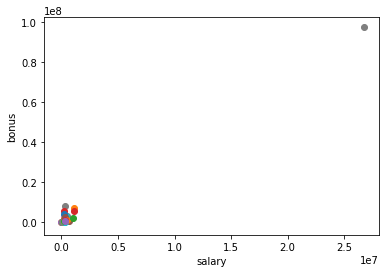

In [19]:
poi_plot.scatterplot(my_dataset, "salary", "bonus")

In [20]:
# Find the outlier with the highest salary
outlier = poi_explore.sort_data(my_dataset, "salary", 1, reverse=True)
outlier_name = poi_explore.get_name(my_dataset, "salary", outlier[0])
print 'Outlier name: {0}'.format(outlier_name)

Outlier name: TOTAL


The plot clearly shows an outlier in the top right of the plot. Ordering the list by salary, the outlier is called "TOTAL", which represents the sum of all the salaries as shown in the Pdf. Since this entry does not represent a person it is invalid and is therefore removed.

In [21]:
# Remove outlier TOTAL from dict and from df
my_dataset.pop('TOTAL', None);
df.drop(axis=0, labels=['TOTAL'], inplace=True)

Scatterplot of Salary vs. Bonus of original dataset after removal of outlier

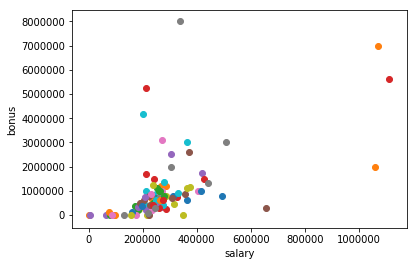

In [22]:
poi_plot.scatterplot(my_dataset, "salary", "bonus")

In [23]:
#Entries in Dict & Dataframe after Cleaning and outlier removal
print (len(my_dataset))
print (len(df))

144
144


After cleaning and outlier removal the data set is left with 144 entries that all represent valid Enron employees.

## Pick Algorithms and first shot performances

The first training and testing runs will be to assess the out-of-the-box performance of several algorithms using all of the 20 features. For this initial step I selected 6 algorithms: GaussianNB, DecisionTreeClassifier, SVC, KMeans, AdaBoostClassifier and RandomForestClassifier. 

I will run the algorithms with the default parameters except I will alter the kernel used in the Support Vector Machine to be linear and I will select the number of clusters = 2 for KMeans as I know in advance that the targets are only two categories that should be classified.

Concerning algorithm performance I will base my assessment on the F1-score. Since the F1-score is a combined measure of precision and recall I think it will serve best our aim to achieve both a good Recall and Precision. For this project the minimum requirement is a precision and recall score of at least 0.3.

In [24]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

import tester

# Create and test the Gaussian Naive Bayes Classifier
clf = GaussianNB()
tester.dump_classifier_and_data(clf, my_dataset, features_list)
tester.main();

GaussianNB(priors=None)
	Accuracy: 0.77220	Precision: 0.25991	Recall: 0.38350	F1: 0.30984	F2: 0.35020
	Total predictions: 15000	True positives:  767	False positives: 2184	False negatives: 1233	True negatives: 10816



In [25]:
# Create and test the Decision Tree Classifier
clf = DecisionTreeClassifier()
tester.dump_classifier_and_data(clf, my_dataset, features_list)
tester.main();

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.81547	Precision: 0.31538	Recall: 0.32800	F1: 0.32157	F2: 0.32540
	Total predictions: 15000	True positives:  656	False positives: 1424	False negatives: 1344	True negatives: 11576



In [26]:
# Create and test the Support Vector Classifier
clf = SVC(kernel='linear', max_iter=1000)
tester.dump_classifier_and_data(clf, my_dataset, features_list)
tester.main();

C:\Users\Rapha\anaconda3\envs\python2\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=1000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
	Accuracy: 0.48540	Precision: 0.14027	Recall: 0.55750	F1: 0.22414	F2: 0.34955
	Total predictions: 15000	True positives: 1115	False positives: 6834	False negatives:  885	True negatives: 6166



In [27]:
# Create and test the K Means clustering classifier
clf = KMeans(n_clusters=2)
tester.dump_classifier_and_data(clf, my_dataset, features_list)
tester.main();

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)
	Accuracy: 0.82960	Precision: 0.20921	Recall: 0.10000	F1: 0.13532	F2: 0.11166
	Total predictions: 15000	True positives:  200	False positives:  756	False negatives: 1800	True negatives: 12244



In [28]:
# Create and test the AdaBoost classifier
clf = AdaBoostClassifier()
tester.dump_classifier_and_data(clf, my_dataset, features_list)
tester.main();

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
	Accuracy: 0.86307	Precision: 0.48133	Recall: 0.34800	F1: 0.40395	F2: 0.36841
	Total predictions: 15000	True positives:  696	False positives:  750	False negatives: 1304	True negatives: 12250



In [29]:
# Create and test the RandomForest classifier
clf = RandomForestClassifier()
tester.dump_classifier_and_data(clf, my_dataset, features_list)
tester.main();

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
	Accuracy: 0.86987	Precision: 0.53715	Recall: 0.17350	F1: 0.26228	F2: 0.20067
	Total predictions: 15000	True positives:  347	False positives:  299	False negatives: 1653	True negatives: 12701



Both GaussianNB and DecisionTreeClassifier achieved a good result in F1-score even exceeding the required 0.3 just out-of-the-box. Also AdaBoostClassifier did a decent job. 

### Cross-validation
By making use of the tester.py script provided from Udacity I could run these training and testing runs with minimal code here. What the tester.py script does, it uses StatifiedShuffleSPlit to split the data into labels and features sets with which the classifier is being trained and tested and then randomly shuffles the data before splitting it again into training and testing sets. This process is being repeated several times. In our case 1000 times since this is the value provided in the tester.py script. This iterative shuffling and splitting is one possible form of what is being referred to as cross-validation. 

Cross-validation prevents one from making the classic mistake of training an algoithm on the same data used to test the algorithm. If this happens, the test results may show that the classifier is accurate, but that is only because the algorithm has seen the testing data before. When the classifier is deployed on new samples, the performance may be poor because it was trained and tuned for a very specific set of instances. The classifier will not be able to generalize to new cases because it is only fit and tuned to the specific samples it is tested on. Cross-validation solves this issue by training and testing on multiple different subsets of the features and labels and is ideal for use on small datasets to avoid overfitting.

## Scaling

Scaling of some sort whether that is Normalization (MinMax scaling) or Standardization is usually necessary because there are different units for the features in the dataset. Scaling creates non-dimensional features such that those features with a larger range of values do not have an undue influence on the classifier. For example, many classifiers calculate the distance between two points by the Euclidean distance. If one of the features has a broad range of values, the distance will be governed by this particular feature. Therefore, the range of all features should be normalized so that each feature contributes approximately proportionately to the final distance.

In the following I will test if feature scaling has a positive effect on the overall algorithm performance. This is not required as per project specifications but rather I will do this out of curiosity. Instead I could have just applied scaling only for algorithms that utilize Euclidian distances which is how one would usually handle it (will be explained at the end of chapter scaling).

I will run the algorithms as I did before only this time with standardized values. Feature standardization makes the values of each feature in the data have zero-mean and unit-variance. Sklearn's preprocessing module provides a scale function which I will use to generate a new dataset with scaled values.

There is also another method from Scikitlearn called 'StandardScaler' which according to the docs is actually the preferred method. The problem with scaling a dataset before splitting it into training and testing sets is that it will bias the model evaluation because information would have leaked from the test set into the training set. This is a common mistake which is why the use of StandardScaler is recommended. In the following I will try both so I can make a cross check between the two methods.

In [30]:
# Scale the dataset and send it back to a dictionary
from sklearn.preprocessing import scale

scaled_df = df.copy()
scaled_df.ix[:,1:] = scale(scaled_df.ix[:,1:])
my_dataset_scaled = scaled_df.to_dict(orient='index')

C:\Users\Rapha\anaconda3\envs\python2\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """


In [31]:
# Create and test the Gaussian Naive Bayes Classifier with scaled data
clf = GaussianNB()
tester.dump_classifier_and_data(clf, my_dataset_scaled, features_list)
tester.main();

GaussianNB(priors=None)
	Accuracy: 0.40013	Precision: 0.16003	Recall: 0.82350	F1: 0.26798	F2: 0.45020
	Total predictions: 15000	True positives: 1647	False positives: 8645	False negatives:  353	True negatives: 4355



In [32]:
# Crosscheck with StandardScaler in a pipeline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

clf = Pipeline([('scaler', StandardScaler()),('classify', GaussianNB())])

tester.dump_classifier_and_data(clf, my_dataset, features_list)
tester.main()

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classify', GaussianNB(priors=None))])
	Accuracy: 0.39780	Precision: 0.15981	Recall: 0.82600	F1: 0.26781	F2: 0.45046
	Total predictions: 15000	True positives: 1652	False positives: 8685	False negatives:  348	True negatives: 4315



Using 'Standard Scaler' within a Pipeline produces nearly the same results. Therefore I conclude that both methods produce valid results. I assume it will be the case also for the other classifiers...

In [33]:
# Create and test the Decision Tree Classifier with scaled data
clf = DecisionTreeClassifier()
tester.dump_classifier_and_data(clf, my_dataset_scaled, features_list)
tester.main();

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.81593	Precision: 0.32060	Recall: 0.34000	F1: 0.33002	F2: 0.33594
	Total predictions: 15000	True positives:  680	False positives: 1441	False negatives: 1320	True negatives: 11559



In [34]:
# Create and test the Support Vector Classifier with scaled data
clf = SVC(kernel='linear', max_iter=1000)
tester.dump_classifier_and_data(clf, my_dataset_scaled, features_list)
tester.main();

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=1000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
	Accuracy: 0.87080	Precision: 0.54247	Recall: 0.19800	F1: 0.29011	F2: 0.22680
	Total predictions: 15000	True positives:  396	False positives:  334	False negatives: 1604	True negatives: 12666



In [35]:
# Create and test the K Means clustering classifier with scaled data
clf = KMeans(n_clusters=2)
tester.dump_classifier_and_data(clf, my_dataset_scaled, features_list)
tester.main();

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)
	Accuracy: 0.80860	Precision: 0.15464	Recall: 0.09750	F1: 0.11960	F2: 0.10528
	Total predictions: 15000	True positives:  195	False positives: 1066	False negatives: 1805	True negatives: 11934



In [36]:
# Create and test the AdaBoost classifier with scaled data
clf = AdaBoostClassifier()
tester.dump_classifier_and_data(clf, my_dataset_scaled, features_list)
tester.main();

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
	Accuracy: 0.86327	Precision: 0.48233	Recall: 0.34800	F1: 0.40430	F2: 0.36853
	Total predictions: 15000	True positives:  696	False positives:  747	False negatives: 1304	True negatives: 12253



In [37]:
# Create and test the RandomForest classifier with scaled data
clf = RandomForestClassifier()
tester.dump_classifier_and_data(clf, my_dataset_scaled, features_list)
tester.main();

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
	Accuracy: 0.86927	Precision: 0.53033	Recall: 0.17050	F1: 0.25804	F2: 0.19727
	Total predictions: 15000	True positives:  341	False positives:  302	False negatives: 1659	True negatives: 12698



## Results from first shots
Unscaled:

| Classifier            | Accuracy | Precision | Recall  | F1 Score |
|-----------------------|----------|-----------|---------|----------|
| GaussianNB            | 0.772    | 0.260     | 0.384   | 0.310    |
| DecisionTree          | 0.815    | 0.315     | 0.328   | 0.322    |
| SVC (kernel='linear') | 0.485    | 0.140     | 0.558   | 0.224    |
| KMeans (n_clusters=2) | 0.829    | 0.209     | 0.100   | 0.135    |
| Adaboost              | 0.863    | 0.481     | 0.348   | 0.404    |
| Random Forest         | 0.870    | 0.537     | 0.174   | 0.262    |

Scaled:

| Classifier            | Accuracy | Precision | Recall  | F1 Score |
|-----------------------|----------|-----------|---------|----------|
| GaussianNB            | 0.400    | 0.160     | 0.824   | 0.268    |
| DecisionTree          | 0.816    | 0.321     | 0.340   | 0.330    |
| SVC (kernel='linear') | 0.871    | 0.542     | 0.198   | 0.290    |
| KMeans (n_clusters=2) | 0.809    | 0.154     | 0.098   | 0.120    |
| Adaboost              | 0.863    | 0.482     | 0.348   | 0.404    |
| Random Forest         | 0.869    | 0.530     | 0.171   | 0.258    |

The results are mixed. For GaussianNB and DecisionTree the scaled data does not bring an improvement whereas for SVC the performance improved considerably. The performances of Random Forest and KMeans improved a little. AdaBoosts' performance did not change at all.

In a way these results confirm kind of what one would already expect. Algorithms where feature scaling matters are ones that utilize Euclidean distances, like K-means or K-nearest neighbors, logistic regression, SVMs, perceptrons, neural networks, etc. For ensemble algorithms like AdaBoost, XGBoost, etc. they depend on the base_classifier. In Sklearn it uses DecisionTree by default thus scaling isn't needed. The DecisionTree itself does not utilize Euclidian distances either.

However one may have expected a visible performance improvement for the KMeans-Algorithm. This I could not observe.

The fact that RandomForest has improved in performance by a minimal fraction is not reason enough for me to apply scaling. Since RF is an ensemble algorithm it normally doens not require scaling. So I won't do it either.

## Feature Engineering

The aim of feature engineering is to increase algorithm performance by creating new features out of existing information. In this case I try to combine existing features with each other in such way that it has a positive effect on the algorithms performance. 

For example the ratios between the email features 'from_poi_to_this_person' and 'to_messages' or 'from_messages' might be a useful combination for the creation of a new feature as it could be the case that somebody went unnoticed with lower email volume, but almost all of it directed to or coming from a POI. I could imagine that in contrast to total numbers these new features based on the percentage of emails to or from POIs will do a better job in revealing the persons with higher communication to POIs. It seems evident that individuals who interact more with a POI are themselves more likely to be a POI.

In [38]:
# Add the new email features to the dataframe
df['to_poi_ratio'] = df['from_poi_to_this_person'] / df['to_messages']
df['from_poi_ratio'] = df['from_this_person_to_poi'] / df['from_messages']

features_list.append('to_poi_ratio')
features_list.append('from_poi_ratio')

In addition I will create two new financial features that are also a combination from already existing features. Namely the fraction of bonus&salary and bonus&total_payments. The reason for choosing these combinations are primarily because I suspect that persons receiving very large bonuses compared to their usual annual income are more likely to be involved in fraudulent activities and therefore be POIs.

In [39]:
# Add the new financial features to the dataframe
df['bonus_to_salary'] = df['bonus'] / df['salary']
df['bonus_to_total'] = df['bonus'] / df['total_payments']

features_list.append('bonus_to_salary')
features_list.append('bonus_to_total')   

In [40]:
print 'Number of features with newly engineered features: {0}'.format(len(df.iloc[0]))

Number of features with newly engineered features: 24


In [41]:
# Fill any NaN financial data with a 0
df.fillna(value= 0, inplace=True)

In [42]:
my_dataset = df.to_dict(orient='index')

In [43]:
#update 'scaled_df', and 'my_dataset_scaled' with new enineered features
scaled_df = df.copy()
scaled_df.ix[:,1:] = scale(scaled_df.ix[:,1:])

my_dataset_scaled = scaled_df.to_dict(orient='index')

C:\Users\Rapha\anaconda3\envs\python2\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until


There are now a total number of 24 features of which I do not yet know if I produced some unnecessary redundancies.
Let's test the performances using the tester.py script and see if the newly engineered features bring some improvement.

In [44]:
clf = GaussianNB()
tester.dump_classifier_and_data(clf, my_dataset, features_list)
tester.main();

GaussianNB(priors=None)
	Accuracy: 0.77220	Precision: 0.25991	Recall: 0.38350	F1: 0.30984	F2: 0.35020
	Total predictions: 15000	True positives:  767	False positives: 2184	False negatives: 1233	True negatives: 10816



In [45]:
clf = DecisionTreeClassifier()
tester.dump_classifier_and_data(clf, my_dataset, features_list)
tester.main();

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.89847	Precision: 0.61955	Recall: 0.61800	F1: 0.61877	F2: 0.61831
	Total predictions: 15000	True positives: 1236	False positives:  759	False negatives:  764	True negatives: 12241



In [107]:
clf = SVC(kernel='linear', max_iter=1000)
tester.dump_classifier_and_data(clf, my_dataset_scaled, features_list)
tester.main();

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=1000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
	Accuracy: 0.85960	Precision: 0.44894	Recall: 0.23300	F1: 0.30678	F2: 0.25780
	Total predictions: 15000	True positives:  466	False positives:  572	False negatives: 1534	True negatives: 12428



In [47]:
clf = KMeans(n_clusters=2)
tester.dump_classifier_and_data(clf, my_dataset, features_list)
tester.main();

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)
	Accuracy: 0.83047	Precision: 0.21807	Recall: 0.10500	F1: 0.14175	F2: 0.11715
	Total predictions: 15000	True positives:  210	False positives:  753	False negatives: 1790	True negatives: 12247



In [48]:
clf = AdaBoostClassifier()
tester.dump_classifier_and_data(clf, my_dataset, features_list)
tester.main();

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
	Accuracy: 0.88000	Precision: 0.56068	Recall: 0.46200	F1: 0.50658	F2: 0.47886
	Total predictions: 15000	True positives:  924	False positives:  724	False negatives: 1076	True negatives: 12276



In [49]:
clf = RandomForestClassifier()
tester.dump_classifier_and_data(clf, my_dataset, features_list)
tester.main();

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
	Accuracy: 0.88073	Precision: 0.63937	Recall: 0.24200	F1: 0.35111	F2: 0.27635
	Total predictions: 15000	True positives:  484	False positives:  273	False negatives: 1516	True negatives: 12727



After adding the new features, the scores for all algorithms have improved or at least remained the same.
KMeans still performes very poorly regarding F1-score and recall so I will drop it for further investigation.

## Results with engineered features
Unscaled:

| Classifier            | Accuracy | Precision | Recall  | F1 Score |
|-----------------------|----------|-----------|---------|----------|
| GaussianNB            | 0.772    | 0.260     | 0.384   | 0.310    |
| DecisionTree          | 0.898    | 0.620     | 0.618   | 0.619    |
| SVC (kernel='linear') | 0.860    | 0.449     | 0.233   | 0.307    |
| KMeans (n_clusters=2) | 0.837    | 0.219     | 0.088   | 0.126    |
| Adaboost              | 0.880    | 0.561     | 0.462   | 0.507    |
| Random Forest         | 0.881    | 0.639     | 0.242   | 0.351    |

Based on the F1-score the DecisionTree is now leading the pack followed by AdaBoost.

## Feature Selection

With overall 24 features this is quite a number. By creating new features I was able to improve performance but I do not yet know if all of the features are really necessary or if I can remove some of them. Having less but important features is not only to be considered as "nice to have" but really an important step to tuning algorithm performance.

One way to perform feature selection is to query the feature importances for a classifier and then modifiy the features list manually to exlude the ones below a certain threshold. In the following I will query the feature importances at the example of DecisionTreeClassifier and AdaBoostClassifier. For each I will print a features list ordered by importance.

In [50]:
clf_tree = DecisionTreeClassifier()
tester.test_classifier(clf_tree, my_dataset, features_list)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.89620	Precision: 0.61159	Recall: 0.60700	F1: 0.60928	F2: 0.60791
	Total predictions: 15000	True positives: 1214	False positives:  771	False negatives:  786	True negatives: 12229



In [51]:
# Get the feature importances of the DecisionTree Classifier
tree_feature_importances = (clf_tree.feature_importances_)
tree_features = zip(tree_feature_importances, features_list[1:])
tree_features = sorted(tree_features, key= lambda x:x[0], reverse=True)

# Display the feature names with 10 highest importance values
print('Tree Feature Importances:\n')
for i in range(10):
    print('{} : {:.4f}'.format(tree_features[i][1], tree_features[i][0]))

Tree Feature Importances:

from_poi_ratio : 0.3521
shared_receipt_with_poi : 0.2094
other : 0.1693
expenses : 0.1469
to_poi_ratio : 0.0688
from_messages : 0.0535
salary : 0.0000
bonus : 0.0000
long_term_incentive : 0.0000
deferred_income : 0.0000


In [52]:
clf_ada = AdaBoostClassifier()
tester.test_classifier(clf_ada, my_dataset, features_list);

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
	Accuracy: 0.88013	Precision: 0.56114	Recall: 0.46350	F1: 0.50767	F2: 0.48021
	Total predictions: 15000	True positives:  927	False positives:  725	False negatives: 1073	True negatives: 12275



In [53]:
# Get the feature importances for the AdaBoost Classifier
ada_feature_importances = clf_ada.feature_importances_
ada_features = zip(ada_feature_importances, features_list[1:])

# Display the feature names with 10 highest importance values
print('Ada Boost Feature Importances:\n')
ada_features = sorted(ada_features, key=lambda x:x[0], reverse=True)
for i in range(10):
    print('{} : {:.4f}'.format(ada_features[i][1], ada_features[i][0]))

Ada Boost Feature Importances:

total_payments : 0.1400
to_poi_ratio : 0.1400
exercised_stock_options : 0.1200
other : 0.1000
from_this_person_to_poi : 0.1000
shared_receipt_with_poi : 0.0800
expenses : 0.0600
from_poi_to_this_person : 0.0600
from_poi_ratio : 0.0600
deferred_income : 0.0400


An interesting observation is that the top 10 features do not really conform. So feature importances can vary quite considerably between different algorithms.

## Evaluation Metrics

When it comes to evaluate an algorithm, there are several evaluation metrics at our disposal, as seen during the whole project. Each of them is a perfectly valid means for evaluation but also typcially favors one type of error which is why we should use different metrics if we want our classifier to be able to generalize on the data.

#### Accuracy

It describes the ratio between the items labeled correctly and all items. In the Enron case, the ratio between correctly identified POIs and all persons.
The difficulty we face in the Enron data is that there are many more non-POIs than POI. This poses the problem that one could simply assign the more common label for all data points and still reach a pretty high Accuracy.

#### Recall
Recall is intuitively the ability of the classifier to find all the positive samples. In the Enron case, Recall describes the ability of the algorithm to correctly identify a POI provided that the person is a POI. Boosting the Recall metric has the affect that the classifier is correctly identifying every single POI. The tradeoff is that the algorithm will be biased towards identifying POIs. In this case this is rather what we want - better make sure no POI gues unnoticed and later declare the misclassified individuals innocent.

#### Precision
Intuitively, precision is the ability of the classifier not to label as positive a sample that is negative. In the Enron case, if the classifier doesn't have great Recall, but it does have good Precision, it means that whenever a POI gets flagged in the test set, there is good confidence that it is a real POI and not a false alarm. The tradeoff is that sometimes real POIs are missed, which in the case of Enron is definitely something we do not want.

#### F1-Score
The F1 score can be interpreted as a weighted average of the precision and recall. The relative contribution of precision and recall to the F1 score are equal. In some way, the F1 score can be thought of "the best of both worlds". It will probably serve as a good metric for most problems and deliver a relatively balanced model. In the Enron case, I would argue that actually a good Recall is more important even at the cost of a lower Precision. But for the purpose of this project I think that optimizing on the F1-score should serve me well. This is accounted for in the code by "scoring='f1'".

## GridSearchCV with SelectKBest

Another means for feature selection is to use SelectKBest which removes all but the k highest scoring features. Only the problem is that we don't yet know the value of k, i.e. the optimal number of features. I could manually play around with k until I assume having found the optimal number but there is a better way...

Namely, what I can do is to combine SelektKBest with GridSearchCV in order to identify the highest scoring features and at the same time find the optimal number of features. To combine these two functions one can use another tool called Pipeline. Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example in feature selection. Using a pipeline one can perform a Grid Search over parameters of all estimators in the pipeline at once.

In [54]:
#splitting data with feature_format.py
from feature_format import featureFormat, targetFeatureSplit

data_dict = featureFormat(my_dataset, features_list)
labels, features = targetFeatureSplit(data_dict)

In [55]:
data_dict_scaled = featureFormat(my_dataset_scaled, features_list)
labels_scaled, features_scaled = targetFeatureSplit(data_dict)

Since I do not want to use the tester.py script like I did before but still need to split my data in labels and features, I can use the *featureFormat*- as well as *targetFeatureSplit*-fuctions from the feature_format.py script to format and split the data.

#### Grid Search with SelektKBest for DecisionTreeClassifier
The pipeline can be used like any other estimator and avoids leaking the test set into the train set.

In [56]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest

# Create a pipeline with feature selection and classification
estimators = [
    ('select_features', SelectKBest()),
    ('classify', DecisionTreeClassifier())
]

n_features = np.arange(1, len(features_list))

param_grid = [{'select_features__k': n_features}]

pipe = Pipeline(estimators)

In [57]:
grid_search_tree = GridSearchCV(pipe, param_grid=param_grid, scoring='f1', cv = 10)
grid_search_tree.fit(features_scaled, labels_scaled)

C:\Users\Rapha\anaconda3\envs\python2\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('select_features', SelectKBest(k=10, score_func=<function f_classif at 0x000000000C4FB5F8>)), ('classify', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'select_features__k': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [58]:
grid_search_tree.best_params_

{'select_features__k': 18}

In [59]:
grid_search_tree.best_score_

0.67245370370370372

The GridSearch with SelectKBest states that the optimal number of features for the DecisionTreeClassifier is 18 out of 24 that we have at our disposal. The corresponding score that was achieved with the 18 best features is not too bad either.

#### Randomized Search with SelektKBest for DecisionTreeClassifier
When tuning the hyperparameters of an estimator, Grid Search and Random Search are both popular methods. According to some publications random search is even perceived as the better method depending on the type of problem. That is why I wanted to see how it performs in direct comparison although the requirement for this project is to use GridSearch.

In [60]:
param_dist = {'select_features__k': n_features}

In [61]:
random_search_tree = RandomizedSearchCV(pipe, param_dist, scoring='f1', cv = 10)
random_search_tree.fit(features, labels)

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=Pipeline(steps=[('select_features', SelectKBest(k=10, score_func=<function f_classif at 0x000000000C4FB5F8>)), ('classify', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))]),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'select_features__k': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='f1', verbose=0)

In [62]:
random_search_tree.best_params_

{'select_features__k': 21}

In [63]:
random_search_tree.best_score_

0.65509259259259267

RandomSearch returns a k-value of 21 resulting in a lower F1-score than with the 18 features that GridSearch identified as best. So in this case GridSearch returns a better result.

#### Grid Search with SelektKBest for AdaBoost Classifier
Same as we just did for DecisionTree now for AdaBosst

In [64]:
# Create a pipeline with feature selection and classification for AdaBoost
estimators = [
    ('select_features', SelectKBest()),
    ('classify', AdaBoostClassifier())
]

n_features = np.arange(1, len(features_list))

param_grid = [{'select_features__k': n_features}]

pipe = Pipeline(estimators)

In [65]:
grid_search_ada = GridSearchCV(pipe, param_grid=param_grid, scoring='f1', cv =10)
grid_search_ada.fit(features, labels)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('select_features', SelectKBest(k=10, score_func=<function f_classif at 0x000000000C4FB5F8>)), ('classify', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'select_features__k': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [66]:
grid_search_ada.best_params_

{'select_features__k': 16}

In [67]:
grid_search_ada.best_score_

0.62152777777777779

#### Randomized Search with SelectKBest for AdaBoostClassifier

In [68]:
param_dist = {'select_features__k': n_features}

In [69]:
random_search_ada = RandomizedSearchCV(pipe, param_dist, scoring='f1', cv = 10)
random_search_ada.fit(features, labels)

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=Pipeline(steps=[('select_features', SelectKBest(k=10, score_func=<function f_classif at 0x000000000C4FB5F8>)), ('classify', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))]),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'select_features__k': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='f1', verbose=0)

In [70]:
random_search_ada.best_params_

{'select_features__k': 16}

In [71]:
random_search_ada.best_score_

0.62152777777777779

For AdaBoost however GridSearchCV and RandomSearch deliver the same results. The optimal number of features found by SelectKBest for the AdaBoostClassifier is 16. 

For the following RandomForest and GaussianNB I will be running SelectKBest in combination with GridSearch since this is actually the requirement for this project and in the previous cases performed best, or at least equally well.

#### Grid Search with SelektKBest for RandomForest

In [72]:
estimators = [
    ('select_features', SelectKBest()),
    ('classify', RandomForestClassifier())
]

n_features = np.arange(1, len(features_list))

param_grid = [{'select_features__k': n_features}]

pipe = Pipeline(estimators)

In [73]:
grid_search_rf = GridSearchCV(pipe, param_grid=param_grid, scoring='f1', cv =10)
grid_search_rf.fit(features, labels)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('select_features', SelectKBest(k=10, score_func=<function f_classif at 0x000000000C4FB5F8>)), ('classify', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impu...mators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'select_features__k': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [74]:
grid_search_rf.best_params_

{'select_features__k': 6}

In [75]:
grid_search_rf.best_score_

0.53356481481481477

For the GridSearch of the RandomForestClassifier I chose to apply scaling since I want to use scaled data also for the final testing. For Random Forest the optimal number of features is 21.

#### Grid Search with SelektKBest for SVM

In [76]:
# Create a pipeline with feature selection and classification for SVC

estimators = [
    ('select_features', SelectKBest()),
    ('scaler', StandardScaler()),
    ('classify', SVC()),
]

n_features = np.arange(1, len(features_list))

param_grid = [{'select_features__k': n_features}]

pipe = Pipeline(estimators)

grid_search_svc = GridSearchCV(pipe, param_grid=param_grid, scoring='f1', cv =10)
grid_search_svc.fit(features, labels)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('select_features', SelectKBest(k=10, score_func=<function f_classif at 0x000000000C4FB5F8>)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classify', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'select_features__k': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [77]:
grid_search_svc.best_params_

{'select_features__k': 3}

In [78]:
grid_search_svc.best_score_

0.13425925925925924

Unfortunately using SelectKBest on SVC did not return a valid result. At least for me 3 features do not really make sense. Therefore I will not do feature selection and run the final classifier with the complete set of features

#### Grid Search with SelektKBest for GaussianNB

In [79]:
# Create a pipeline with feature selection and classification for SVC

estimators = [
    ('select_features', SelectKBest()),
    ('classify', GaussianNB()),
]

n_features = np.arange(1, len(features_list))

param_grid = [{'select_features__k': n_features}]

pipe = Pipeline(estimators)

grid_search_gnb = GridSearchCV(pipe, param_grid=param_grid, scoring='f1', cv =10)
grid_search_gnb.fit(features, labels)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('select_features', SelectKBest(k=10, score_func=<function f_classif at 0x000000000C4FB5F8>)), ('classify', GaussianNB(priors=None))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'select_features__k': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [80]:
grid_search_gnb.best_params_

{'select_features__k': 22}

In [81]:
grid_search_gnb.best_score_

0.37638888888888888

For GaussionNB the optimal number of features is 22.

## Testing the classifiers with optimal number of features
Now that I know the optimal number of features for each individual classifier I want to test the classifiers with their respective best number of features using the tester.py script.

In [89]:
# Create the classifier with the optimal hyperparameters as found by GridSearchCV
tree_clf_kbest = Pipeline([
    ('select_features', SelectKBest(k=18)),
    ('classify', DecisionTreeClassifier()),
])
# Test the classifier using tester.py
tester.dump_classifier_and_data(tree_clf_kbest, my_dataset, features_list)
tester.main()

Pipeline(steps=[('select_features', SelectKBest(k=18, score_func=<function f_classif at 0x000000000C4FB5F8>)), ('classify', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])
	Accuracy: 0.89927	Precision: 0.62367	Recall: 0.61650	F1: 0.62007	F2: 0.61792
	Total predictions: 15000	True positives: 1233	False positives:  744	False negatives:  767	True negatives: 12256



For the DecisionTree again I took the unscaled data. I tried both but the unscaled yielded a higher performance here even though in the out-of-the-box run it performed better with the scaled data.

In [90]:
# Create the classifier with the optimal hyperparameters as found by GridSearchCV
ada_clf_kbest = Pipeline([
    ('select_features', SelectKBest(k=16)),
    ('classify', AdaBoostClassifier()),
])
# Test the classifier using tester.py
tester.dump_classifier_and_data(ada_clf_kbest, my_dataset, features_list)
tester.main()

Pipeline(steps=[('select_features', SelectKBest(k=16, score_func=<function f_classif at 0x000000000C4FB5F8>)), ('classify', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))])
	Accuracy: 0.88927	Precision: 0.60180	Recall: 0.50100	F1: 0.54679	F2: 0.51837
	Total predictions: 15000	True positives: 1002	False positives:  663	False negatives:  998	True negatives: 12337



In [91]:
# Create the classifier with the optimal hyperparameters as found by GridSearchCV
rf_clf_kbest = Pipeline([
    ('select_features', SelectKBest(k=6)),
    ('classify', RandomForestClassifier()),
])
# Test the classifier using tester.py
tester.dump_classifier_and_data(rf_clf_kbest, my_dataset, features_list)
tester.main()

Pipeline(steps=[('select_features', SelectKBest(k=6, score_func=<function f_classif at 0x000000000C4FB5F8>)), ('classify', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])
	Accuracy: 0.86853	Precision: 0.51333	Recall: 0.26950	F1: 0.35344	F2: 0.29779
	Total predictions: 15000	True positives:  539	False positives:  511	False negatives: 1461	True negatives: 12489



In [94]:
# Create the classifier with the optimal hyperparameters as found by GridSearchCV
gnb_clf_kbest = Pipeline([
    ('select_features', SelectKBest(k=22)),
    ('classify', GaussianNB()),
])
# Test the classifier using tester.py
tester.dump_classifier_and_data(gnb_clf_kbest, my_dataset, features_list)
tester.main()

Pipeline(steps=[('select_features', SelectKBest(k=22, score_func=<function f_classif at 0x000000000C4FB5F8>)), ('classify', GaussianNB(priors=None))])
	Accuracy: 0.77707	Precision: 0.26569	Recall: 0.38100	F1: 0.31306	F2: 0.35057
	Total predictions: 15000	True positives:  762	False positives: 2106	False negatives: 1238	True negatives: 10894



## Hyperparameter Tuning

https://en.wikipedia.org/wiki/Hyperparameter_optimization

In machine learning, hyperparameter optimization or tuning is the problem of choosing a set of optimal hyperparameters for a learning algorithm. A hyperparameter is a parameter whose value is used to control the learning process. The same kind of machine learning model can require different constraints, weights or learning rates to generalize different data patterns. These measures are called hyperparameters, and have to be tuned so that the model can optimally solve the machine learning problem.Cross-validation is often used to estimate this generalization performance.
The traditional way of performing hyperparameter optimization is grid search or randomized search. Grid search is simply an exhaustive searching through a manually specified subset of the hyperparameter space of a learning algorithm. A grid search algorithm must be guided by some performance metric, typically measured by cross-validation on the training set or evaluation on a held-out validation set.
Random Search replaces the exhaustive enumeration of all combinations by selecting them randomly. It can outperform Grid search, especially when only a small number of hyperparameters affects the final performance of the machine learning algorithm.

#### Decision Tree

In [95]:
# Create a pipeline with feature selection and classifier

tree_pipe = Pipeline([
    ('select_features', SelectKBest(k=18)),
    ('classify', DecisionTreeClassifier()),
])

# Define the configuration of parameters to test with the 
# Decision Tree Classifier
param_grid = dict(classify__criterion = ['gini', 'entropy'],
                  classify__splitter = ['best', 'random'],
                  classify__max_depth = [None, 5, 10, 15, 20],
                  classify__min_samples_split = [2, 4, 6, 8, 10, 20, 40],
                  classify__min_samples_leaf = [2, 4, 6, 8, 10, 20, 40],
                  classify__max_features = [None, 'sqrt', 'log2', 'auto'])

# Use GridSearchCV to find the optimal hyperparameters for the classifier
tree_clf_tuned = GridSearchCV(tree_pipe, param_grid = param_grid, scoring='f1', cv=10)
tree_clf_tuned.fit(features, labels)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('select_features', SelectKBest(k=18, score_func=<function f_classif at 0x000000000C4FB5F8>)), ('classify', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'classify__splitter': ['best', 'random'], 'classify__criterion': ['gini', 'entropy'], 'classify__min_samples_split': [2, 4, 6, 8, 10, 20, 40], 'classify__max_depth': [None, 5, 10, 15, 20], 'classify__max_features': [None, 'sqrt', 'log2', 'auto'], 'classify__min_samples_leaf': [2, 4, 6, 8, 10, 20, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [96]:
tree_clf_tuned.best_score_

0.7592592592592593

In [97]:
tree_clf_tuned.best_params_

{'classify__criterion': 'entropy',
 'classify__max_depth': None,
 'classify__max_features': None,
 'classify__min_samples_leaf': 2,
 'classify__min_samples_split': 20,
 'classify__splitter': 'best'}

#### AdaBoost

In [98]:
from sklearn.ensemble import RandomForestClassifier

# Create the pipeline with feature selection and AdaBoostClassifier
ada_pipe = Pipeline([('select_features', SelectKBest(k=16)),
                     ('classify', AdaBoostClassifier())
                    ])

# Define the parameter configurations to test with GridSearchCV
param_grid = dict(classify__base_estimator=[DecisionTreeClassifier(), RandomForestClassifier(), GaussianNB()],
                  classify__n_estimators = [50, 100, 150, 200],
                  classify__learning_rate = [0.5, 1, 1.5, 2, 4])

# Use GridSearchCV to automate the process of finding the optimal parameters
ada_clf_tuned = GridSearchCV(ada_pipe, param_grid=param_grid, scoring='f1', cv=10)
ada_clf_tuned.fit(features, labels)

C:\Users\Rapha\anaconda3\envs\python2\lib\site-packages\sklearn\naive_bayes.py:232: RuntimeWarning: invalid value encountered in divide
  new_mu = np.average(X, axis=0, weights=sample_weight / n_new)
C:\Users\Rapha\anaconda3\envs\python2\lib\site-packages\sklearn\naive_bayes.py:234: RuntimeWarning: invalid value encountered in divide
  weights=sample_weight / n_new)
C:\Users\Rapha\anaconda3\envs\python2\lib\site-packages\sklearn\naive_bayes.py:427: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
C:\Users\Rapha\anaconda3\envs\python2\lib\site-packages\sklearn\ensemble\weight_boosting.py:288: RuntimeWarning: invalid value encountered in less
  proba[proba < np.finfo(proba.dtype).eps] = np.finfo(proba.dtype).eps
C:\Users\Rapha\anaconda3\envs\python2\lib\site-packages\sklearn\ensemble\weight_boosting.py:603: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
C:\Users\Rapha\anaconda3\envs\python2\lib\s

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('select_features', SelectKBest(k=16, score_func=<function f_classif at 0x000000000C4FB5F8>)), ('classify', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'classify__learning_rate': [0.5, 1, 1.5, 2, 4], 'classify__n_estimators': [50, 100, 150, 200], 'classify__base_estimator': [DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07..._score=False, random_state=None,
            verbose=0, warm_start=False), GaussianNB(priors=None)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [99]:
ada_clf_tuned.best_score_

0.66435185185185186

In [100]:
ada_clf_tuned.best_params_

{'classify__base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=None, splitter='best'),
 'classify__learning_rate': 4,
 'classify__n_estimators': 200}

#### RandomForest

In [101]:
# Create a pipeline with feature selection and classifier
rf_pipe = Pipeline([
    ('select_features', SelectKBest(k=6)),
    ('classify', RandomForestClassifier()),
])

# Define the configuration of parameters to test with the 
# Random Forest Classifier
param_grid = dict(classify__n_estimators = [5, 10, 50, 100, 200],
                  classify__criterion = ['gini', 'entropy'],
                  classify__max_depth = [None, 4, 5, 6, 7, 8],
#                  classify__min_samples_split = [2, 4, 6, 8, 10, 20],
#                  classify__min_samples_leaf = [2, 4, 6, 8, 10, 20],
#                  classify__max_features = [None, 'sqrt', 'log2', 'auto']
                 )

# Use GridSearchCV to find the optimal hyperparameters for the classifier
rf_clf_tuned = GridSearchCV(rf_pipe, param_grid = param_grid, scoring='f1', cv=10)
rf_clf_tuned.fit(features, labels)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('select_features', SelectKBest(k=6, score_func=<function f_classif at 0x000000000C4FB5F8>)), ('classify', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impur...mators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'classify__n_estimators': [5, 10, 50, 100, 200], 'classify__criterion': ['gini', 'entropy'], 'classify__max_depth': [None, 4, 5, 6, 7, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [102]:
rf_clf_tuned.best_score_

0.51851851851851849

In [103]:
rf_clf_tuned.best_params_

{'classify__criterion': 'entropy',
 'classify__max_depth': 6,
 'classify__n_estimators': 10}

Random Forest comes with a bunch of parameters. I opted for *'criterion', 'max_depth', 'n_estimator'*. When I select more than that(like the ones that are commented out in above code) the process would take unreasonably long or would not terminate at all.

#### SVC

In [104]:
#Using scaling on SVC-classifier since I already saw in chapter "Scaling" that it tends to improve performance on SVC
# Create a pipeline with feature selection and classifier
svm_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classify', SVC()),
])

# Define the configuration of parameters to test with the SVC Classifier
param_grid = ([{'classify__C': [1, 50, 100, 1000],
                'classify__gamma': [0.5, 0.1, 0.01],
                'classify__degree': [1, 2],
                'classify__kernel': ['rbf', 'poly', 'linear'],
                'classify__max_iter': [1, 100, 1000]}])

# Use GridSearchCV to find the optimal hyperparameters for the classifier
svm_clf_tuned = GridSearchCV(svm_pipe, param_grid = param_grid, scoring='f1', cv=10)
svm_clf_tuned.fit(features, labels)

C:\Users\Rapha\anaconda3\envs\python2\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\Rapha\anaconda3\envs\python2\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classify', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'classify__C': [1, 50, 100, 1000], 'classify__degree': [1, 2], 'classify__max_iter': [1, 100, 1000], 'classify__gamma': [0.5, 0.1, 0.01], 'classify__kernel': ['rbf', 'poly', 'linear']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [105]:
svm_clf_tuned.best_score_

0.57407407407407396

In [106]:
svm_clf_tuned.best_params_

{'classify__C': 1000,
 'classify__degree': 1,
 'classify__gamma': 0.01,
 'classify__kernel': 'rbf',
 'classify__max_iter': 100}

#### GaussianNB

For GaussianNB there are no hyperparameters avaiable to tune.

Here is a summary of the hyperparameters obtained from GridSearch and SelectKBest:

__Decision Tree Classifier__:

| Parameter         | SelectKBest | criterion | max_depth | max_features | min\_samples\_split | min\_samples\_leaf | splitter |
|------------------ |-------------|-----------|-----------|--------------|---------------------|--------------------|----------|
| __Optimal Value__ |      18     | 'entropy' |    None   |     None     |          20         |          2         |   best   |

__AdaBoost Classifier__:

| Parameter         | SelectKBest | base\_estimator        | learning\_rate | n\_estimators |
|-------------------|-------------|------------------------|----------------|---------------|
| __Optimal Value__ |      16     | DecisionTreeClassifier |       4        |      200      |

__Random Forest Classifier__:

| Parameter         | SelectKBest | criterion | max_depth | n_estimators |
|------------------ |-------------|-----------|-----------|--------------|
| __Optimal Value__ |      6      | 'entropy' |     6     |      10      |

__SVC Classifier__:

| Parameter         |  'C' | degree | gamma | kernel | max\_iter |
|-------------------|------|--------|-------|--------|-----------|
| __Optimal Value__ | 1000 |    1   |  0.01 |   rbf  |     100   |

__Gaussian Naive Bayes__:

| Parameter         | SelectKBest |
|-------------------|-------------|
| __Optimal Value__ |      22     |

## Final Test
The final step is to implement the optimal hyper parameters into the models and to finally test the classifiers with that configuration using the provided tester function.

#### Decision Tree

In [108]:
tester.dump_classifier_and_data(tree_clf_tuned.best_estimator_, my_dataset, features_list)
tester.main()

Pipeline(steps=[('select_features', SelectKBest(k=18, score_func=<function f_classif at 0x000000000C4FB5F8>)), ('classify', DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=2,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])
	Accuracy: 0.92333	Precision: 0.68398	Recall: 0.79000	F1: 0.73318	F2: 0.76625
	Total predictions: 15000	True positives: 1580	False positives:  730	False negatives:  420	True negatives: 12270



Cross Check: In above cell I queried the results from the DecisionTreeClassifier with the optimal parameters found by grid search using ".best_estimator_". As a cross check I will again build a classifier manually with these exact parameters. The results should be identical. And indeed they are.

In [109]:
# Implement the Decision Tree Classifier with the optimal parameters
tree_clf_final = Pipeline([
    ('select_features', SelectKBest(k=18)),
    ('classify', DecisionTreeClassifier(criterion='entropy', splitter='best' ,max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=20))
])

# Test the classifier with cross-validation
tester.dump_classifier_and_data(tree_clf_final, my_dataset, features_list)
tester.main()

Pipeline(steps=[('select_features', SelectKBest(k=18, score_func=<function f_classif at 0x000000000C4FB5F8>)), ('classify', DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=2,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])
	Accuracy: 0.92240	Precision: 0.68017	Recall: 0.78900	F1: 0.73056	F2: 0.76453
	Total predictions: 15000	True positives: 1578	False positives:  742	False negatives:  422	True negatives: 12258



#### AdaBoost

In [110]:
# Test the classifier with cross-validation
tester.dump_classifier_and_data(ada_clf_tuned.best_estimator_, my_dataset, features_list)
tester.main()

Pipeline(steps=[('select_features', SelectKBest(k=16, score_func=<function f_classif at 0x000000000C4FB5F8>)), ('classify', AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_node...ndom_state=None, splitter='best'),
          learning_rate=4, n_estimators=200, random_state=None))])
	Accuracy: 0.89887	Precision: 0.62391	Recall: 0.60800	F1: 0.61585	F2: 0.61112
	Total predictions: 15000	True positives: 1216	False positives:  733	False negatives:  784	True negatives: 12267



#### Random Forest

In [111]:
tester.dump_classifier_and_data(rf_clf_tuned.best_estimator_, my_dataset, features_list)
tester.main()

Pipeline(steps=[('select_features', SelectKBest(k=6, score_func=<function f_classif at 0x000000000C4FB5F8>)), ('classify', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])
	Accuracy: 0.86600	Precision: 0.49545	Recall: 0.27200	F1: 0.35119	F2: 0.29897
	Total predictions: 15000	True positives:  544	False positives:  554	False negatives: 1456	True negatives: 12446



#### SVC

In [112]:
tester.dump_classifier_and_data(svm_clf_tuned.best_estimator_, my_dataset, features_list)
tester.main()

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classify', SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=1, gamma=0.01, kernel='rbf',
  max_iter=100, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
	Accuracy: 0.89020	Precision: 0.60376	Recall: 0.51350	F1: 0.55499	F2: 0.52933
	Total predictions: 15000	True positives: 1027	False positives:  674	False negatives:  973	True negatives: 12326



In case of the SVC I applied standard scaling since SVMs require standardized data. 

#### GaussianNB

No parameter tuning performed. Hence, same results as in chapter "Testing the classifiers with optimal number of features".

In [113]:
tester.dump_classifier_and_data(gnb_clf_kbest, my_dataset, features_list)
tester.main()

Pipeline(steps=[('select_features', SelectKBest(k=22, score_func=<function f_classif at 0x000000000C4FB5F8>)), ('classify', GaussianNB(priors=None))])
	Accuracy: 0.77707	Precision: 0.26569	Recall: 0.38100	F1: 0.31306	F2: 0.35057
	Total predictions: 15000	True positives:  762	False positives: 2106	False negatives: 1238	True negatives: 10894



At last here is a summary of my final results:

| Algorithm    | Accuracy | Precision | Recall | F1 Score |
|--------------|----------|-----------|--------|----------|
| DecisionTree | 0.923    | 0.684     | 0.790  | 0.733    |
| AdaBoost     | 0.899    | 0.624     | 0.608  | 0.616    |
| RandomForest | 0.866    | 0.495     | 0.272  | 0.351    |
| SVC          | 0.890    | 0.604     | 0.514  | 0.555    |
| GaussianNB   | 0.777    | 0.266     | 0.381  | 0.313    |

The best performing algorithm is pretty clearly the DecisionTreeClassifier. No huge surprise though, since it has already ranged among the best algorithms in the out-of-the-box runs. So if I were to build up a model to identify POIs with machine learning the DecisionTreeClassifier would be the algorithm of my choice. 

The weakest performance delivered GaussianNB and RandomForest not even reaching the minimum requirements of this project of 0.3 for precision respectively recall. GaussianNB did not perform too bad in the initial runs but due to the fact that it does not come with any hyperparameter tuning options I was not able to enhance the performance. RandomForest is said to be a very powerful ensemble-algorithm, which is why I did not want to give up on it until the very end hoping that hyperparameter tuning would have a significant effect, but unfortunately not.

## Conclusion

In the process of the project I happened to mix up the terms 'Overfitting' and 'Data Leakage'. Maybe because I didn't fully understand the difference. I thought all of this is kind of what is being referred to as 'Overfitting'. Maybe because both classic overfitting and data leakage will result in a model performing well on training data but poorly on unseen 'real world' data. But nevertheless I think one needs to distinguish between the two. 

Overfitting is a complex issue of which every aspiring machine learner should be aware. That is why I want to dedicate my conclusion to this topic.

#### What is Overfitting?
In order to evaluate the performance of a particular ML model, we invariably split the data into two sets including training and testing subsets. The algorithm is trained on the training dataset and evaluated/tested on the test dataset, then it is applied to make predictions on new (unseen) data points. Overfitting occurs when the model performs too well on the training data but poorly on the new data points while the goal is to maximize its accuracy on the unseen data points. This means that the model fails to generalize to unseen data.

I would describe classic overfitting at following example:

For example, in its fundamental nature, an SVC classifier works by recursively drawing a boundary between different classes on the data, that maximizes the distance to the nearest point, also called the margin.

On the one hand this boundary can be as simplistic as a straight line, which generalizes well but doesn't yield optimal results out of a particular situation. On the other hand it can be a twisted, wiggled boundary with an exceptional fit for that situation, but it wouldn't fit other situations. In this case our classifier would be somehow biased by the data and that's a clear example of overfitting. 

To avoid such an overfit situation but still yield a good performance we have to find the optimal hyperparameters. This can for example be done using GridSearch or Random Search, as we did in our project.

#### How to avoid Overfitting:

Source: https://elitedatascience.com/overfitting-in-machine-learning

1. Perform Cross Validation
2. Train with more data
3. Remove features
4. Early stopping
5. Regularization
6. Ensembling

#### What is Data Leakage?
When the data you are using to train a machine learning algorithm happens to have the information you are trying to predict.

#### Overfitting vs. Data Leakage
When data leakage occurs, it may lead to overfitting (overly optimistic training accuracy) but the model also performs too well on the test data. As we mentioned, data points are leaked from test set into training set, which means the model will predict something it learned/saw (but we think it is unseen data points) while overfitting may lead to poor generalization performance of a predictive model.

#### How to avoid Data Leackage:

Source: https://machinelearningmastery.com/data-leakage-machine-learning/

1. Perform data preparation within cross validation folds
2. Hold back a validation dataset

Generally, it is good practice to use both of these techniques.

1. Perform Data Preparation Within Cross Validation Folds
You can easily leak information when preparing your data for machine learning. The effect is overfitting your training data and having an overly optimistic evaluation of your models performance on unseen data. For example, if you normalize or standardize your entire dataset, then estimate the performance of your model using cross validation, you have committed the sin of data leakage.The data rescaling process that you performed had knowledge of the full distribution of data in the training dataset when calculating the scaling factors (like min and max or mean and standard deviation). This knowledge was stamped into the rescaled values and exploited by all algorithms in your cross validation test harness. A non-leaky evaluation of machine learning algorithms in this situation would calculate the parameters for rescaling data within each fold of the cross validation and use those parameters to prepare the data on the held out test fold on each cycle.

2. Hold Back a Validation Dataset
Another, perhaps simpler approach is to split your training dataset into train and validation sets, and store away the validation dataset. Once you have completed your modeling process and actually created your final model, evaluate it on the validation dataset. This can give you a sanity check to see if your estimation of performance has been overly optimistic and has leaked.